In [1]:
import os
import time
from datetime import date, datetime, timedelta
import pytz

today_str = datetime.now(pytz.timezone('Europe/Berlin')).strftime('%Y-%m-%d')

date_to_process_str = os.environ.get('DTP')

if type(date_to_process_str) != str or date_to_process_str >= today_str:
  date_to_process_str = today_str
date_to_process = datetime.strptime(date_to_process_str, '%Y-%m-%d').date()

print(f'Running update for {date_to_process_str}')

Running update for 2022-02-11


In [2]:
sdp_all = date_to_process_str <= '2022-02-01'

In [3]:
# if no dtp specified -> process newest data
import urllib.request

urllib.request.urlretrieve("https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Sequenzdaten_Deutschland.csv.xz", "meta.csv.xz")
urllib.request.urlretrieve("https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Entwicklungslinien_Deutschland.csv.xz", "variants.csv.xz")
urllib.request.urlretrieve("https://covid.ourworldindata.org/data/owid-covid-data.csv", "owid-covid-data.csv")

os.system('xz -d -k meta.csv.xz')
os.system('xz -d -k variants.csv.xz')

0

In [4]:
import numpy as np
import pandas as pd

In [5]:
lineage_file = 'variants.csv'
meta_file = 'meta.csv'

In [6]:
lineage = pd.read_csv(lineage_file)
meta = pd.read_csv(meta_file)
data = pd.merge(lineage, meta, left_on='IMS_ID', right_on='IMS_ID', how='left')
data = data[(data.SEQ_REASON.isin(['N'])) & (data.DATE_DRAW <= date_to_process_str)] # filter for random samples

In [7]:
len(data.index)

236675

In [8]:
scorpios = data.scorpio_call.unique()
scorpios

array(['Alpha (B.1.1.7-like)', nan, 'Beta (B.1.351-like)',
       'Eta (B.1.525-like)', 'Zeta (P.2-like)', 'B.1.1.318-like',
       'Lambda (C.37-like)', 'Epsilon (B.1.427-like)', 'A.23.1-like',
       'Gamma (P.1-like)', 'Iota (B.1.526-like)', 'B.1.1.7-like+E484K',
       'Epsilon (B.1.429-like)', 'B.1.617.1-like', 'Theta (P.3-like)',
       'Delta (B.1.617.2-like)', 'Mu (B.1.621-like)',
       'Delta (B.1.617.2-like) +K417N', 'Delta (AY.4-like)',
       'Delta (AY.4.2-like)', 'Omicron (BA.1-like)',
       'Probable Omicron (BA.1-like)', 'Probable Omicron (Unassigned)',
       'Omicron (Unassigned)', 'Omicron (BA.2-like)',
       'Omicron (BA.3-like)', 'Probable Omicron (BA.3-like)',
       'Probable Omicron (BA.2-like)'], dtype=object)

In [9]:
alphabet = ['alpha', 'beta', 'eta', 'zeta', 'lambda', 'gamma', 'epsilon', 'theta', 'iota', 'epsilon', 'delta', 'mu', 'omicron']
alphabet_lineage = ['BA.1', 'BA.2', 'BA.3']
lineage_map = {
    'BA.1': 'ba1',
    'BA.2': 'ba2',
    'BA.3': 'ba3',
}

In [10]:
data['variant'] = data.scorpio_call
for letter in alphabet:
    data['variant'] = data['variant'] \
        .mask(data['variant'] \
            .isin([s for s in list(scorpios) if letter in str(s).lower()]), 
            letter.capitalize()
        )

In [11]:
# add sub-lineage BA.1.1 to BA.1
data.loc[data.lineage == 'BA.1.1', 'lineage'] = 'BA.1'

In [12]:
grouped_data = data.groupby(['DATE_DRAW', 'variant']).size()
grouped_data_lineage = data.groupby(['DATE_DRAW', 'lineage']).size()

In [13]:
daily_totals = data.groupby('DATE_DRAW').size()

### Group and calc relatives

In [14]:
agg_data_list = []
for date in data.DATE_DRAW.unique():
    if date not in grouped_data and date not in grouped_data_lineage: continue
    #total = 0
    total = daily_totals[date]
    entry = {'date': date}
    variant_sum = 0
    for variant in data.variant.unique():
        #total += grouped_data[date, variant] if variant in grouped_data[date] else 0
        if str(variant).lower() not in alphabet: continue
        entry[str(variant).lower()] = grouped_data[date, variant] if date in grouped_data and variant in grouped_data[date] else 0
        variant_sum += entry[str(variant).lower()]
    for variant in data.variant.unique():
        if str(variant).lower() not in alphabet: continue
        entry[str(variant).lower() + '_rel'] = entry[str(variant).lower()] / total
    entry['other'] = total - variant_sum
    entry['other_rel'] = (total - variant_sum) / total
    entry['sum'] = total

    # separately count omicron lineages
    for lineage in alphabet_lineage:
      entry[lineage_map[lineage]] = grouped_data_lineage[date, lineage] if date in grouped_data_lineage and lineage in grouped_data_lineage[date] else 0
      entry[lineage_map[lineage] + '_rel'] = entry[lineage_map[lineage]] / total

    agg_data_list.append(entry)

agg_data = pd.DataFrame(agg_data_list)
agg_data.sort_values('date', axis=0, inplace=True)
agg_data.reset_index(drop=True, inplace=True)
agg_data

,date,alpha,beta,eta,lambda,epsilon,gamma,iota,delta,mu,...,omicron_rel,other,other_rel,sum,ba1,ba1_rel,ba2,ba2_rel,ba3,ba3_rel
0,2020-01-13,0,0,0,0,0,0,0,0,0,...,1.000000,0,0.0,1,1,1.000000,0,0.000000,0,0.000000
1,2020-01-14,0,0,0,0,0,0,0,0,0,...,1.000000,0,0.0,1,1,1.000000,0,0.000000,0,0.000000
2,2020-01-29,0,0,0,0,0,0,0,0,0,...,0.000000,1,1.0,1,0,0.000000,0,0.000000,0,0.000000
3,2020-01-30,0,0,0,0,0,0,0,0,0,...,0.000000,1,1.0,1,0,0.000000,0,0.000000,0,0.000000
4,2020-01-31,0,0,0,0,0,0,0,0,0,...,0.000000,1,1.0,1,0,0.000000,0,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,2022-02-03,0,0,0,0,0,0,0,6,0,...,0.981651,0,0.0,327,257,0.785933,60,0.183486,1,0.003058
582,2022-02-04,0,0,0,0,0,0,0,2,0,...,0.993569,0,0.0,311,266,0.855305,43,0.138264,0,0.000000
583,2022-02-05,0,0,0,0,0,0,0,0,0,...,1.000000,0,0.0,89,76,0.853933,12,0.134831,0,0.000000
584,2022-02-06,0,0,0,0,0,0,0,1,0,...,0.992248,0,0.0,129,107,0.829457,21,0.162791,0,0.000000


### Calc rolling averages

In [15]:
agg_data_rolling = agg_data.rolling(window=3).mean()
agg_data_rolling['date'] = agg_data['date']
agg_data_rolling.dropna(inplace=True)
#agg_data_rolling = agg_data_rolling[agg_data_rolling.sum > 100]
agg_data_rolling.dtypes

/tmp/ipykernel_2137/2979982979.py:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  agg_data_rolling = agg_data.rolling(window=3).mean()


alpha          float64
beta           float64
eta            float64
lambda         float64
epsilon        float64
gamma          float64
iota           float64
delta          float64
mu             float64
omicron        float64
alpha_rel      float64
beta_rel       float64
eta_rel        float64
lambda_rel     float64
epsilon_rel    float64
gamma_rel      float64
iota_rel       float64
delta_rel      float64
mu_rel         float64
omicron_rel    float64
other          float64
other_rel      float64
sum            float64
ba1            float64
ba1_rel        float64
ba2            float64
ba2_rel        float64
ba3            float64
ba3_rel        float64
date            object
dtype: object

### Calc logarithmic fit

In [16]:
from scipy.optimize import curve_fit
from datetime import date
from functools import partial

def sigmoid(x, x0, k, max=1):
    y = max / (1 + np.exp(-k*(x-x0)))
    return (y)

def sigmoid_x(y, x0, k, max=1):
    return (x0 + np.log(1/y - 1) / (-k)) / max


def fit(df, col, f, start='2021-01-01', end=None, add_days=None, method='lm', p0=None):

    if start: df_tmp = df[df.date >= start]
    if end and type(end) == str: df_tmp = df[df.date <= end]
    elif end and type(end) == int: df_tmp = df_tmp.iloc[:end]

    xdata = df_tmp.index # should use date
    ydata = df_tmp[col]

    if not p0:
      p0 = [np.median(xdata),1] # this is an mandatory initial guess

    popt, pcov = curve_fit(f, xdata, ydata,p0, method=method, maxfev=1000000000000)

    df_out = pd.DataFrame({'date': df.date})
    df_out.index = df.index
    
    if add_days:
        last_day = time.strptime(df.iloc[-1]['date'], '%Y-%m-%d')
        for i in range(add_days):
            day_str = (date(last_day.tm_year, last_day.tm_mon, last_day.tm_mday) + timedelta(i+1)).strftime('%Y-%m-%d')
            df_out = df_out.append({'date': day_str}, ignore_index=True)
            
    df_out['fit'] = f(df_out.index, *popt)

    return df_out, popt

delta_growth_fit, popt_dgf = fit(agg_data, 'delta_rel', sigmoid, '2021-02-15', '2021-11-01', method='dogbox', p0=[1.76120820e+02, 1.24058886e-01])
omicron_growth_fit, popt_ogf = fit(agg_data, 'omicron_rel', sigmoid, '2021-11-01', -3, 50, method='dogbox')
ba1_growth_fit, popt_ba1gf = fit(agg_data, 'ba1_rel', sigmoid, '2021-11-01', -3, 50, method='dogbox')
ba2_growth_fit, popt_ba2gf = fit(agg_data, 'ba2_rel', sigmoid, '2021-12-20', -3, 50, method='dogbox')

delta_vs_omicron_offset = -200 # days

/tmp/ipykernel_2137/1515826766.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_out = df_out.append({'date': day_str}, ignore_index=True)
/tmp/ipykernel_2137/1515826766.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_out = df_out.append({'date': day_str}, ignore_index=True)
/tmp/ipykernel_2137/1515826766.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_out = df_out.append({'date': day_str}, ignore_index=True)
/tmp/ipykernel_2137/1515826766.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_out = df_out.append({'date': day_str}, ignore_index=True)
/tmp/ipykernel_2137/1515826766.py:34: FutureWarning: The frame.a

In [17]:
omicron_growth_fit

,date,fit
0,2020-01-13,2.131612e-38
1,2020-01-14,2.499562e-38
2,2020-01-29,2.931025e-38
3,2020-01-30,3.436966e-38
4,2020-01-31,4.030240e-38
...,...,...
631,2022-03-25,9.999989e-01
632,2022-03-26,9.999991e-01
633,2022-03-27,9.999992e-01
634,2022-03-28,9.999993e-01


### Daily new cases

In [18]:
owid_data = pd.read_csv('owid-covid-data.csv')
owid_data_ger = owid_data[owid_data.iso_code == 'DEU']
owid_data_ger = owid_data_ger[owid_data_ger.date <= date_to_process_str]
owid_data_ger.tail()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
56408,DEU,Europe,Germany,2022-02-06,11147509.0,82363.0,185925.286,118771.0,49.0,140.143,...,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN
56409,DEU,Europe,Germany,2022-02-07,11198886.0,51377.0,167631.857,118792.0,21.0,116.143,...,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN
56410,DEU,Europe,Germany,2022-02-08,11579518.0,380632.0,191825.429,119219.0,427.0,149.143,...,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN
56411,DEU,Europe,Germany,2022-02-09,11832331.0,252813.0,193905.571,119457.0,238.0,159.714,...,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN
56412,DEU,Europe,Germany,2022-02-10,12068411.0,236080.0,192109.571,119685.0,228.0,168.143,...,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN


In [19]:
abs_data = agg_data_rolling[['date','delta_rel','omicron_rel', 'ba1_rel', 'ba2_rel']]
abs_data = abs_data[abs_data.date >= '2021-11-23'] # from 11/23 omicron started to appear

abs_data = pd.merge(abs_data, owid_data_ger[['date', 'new_cases_smoothed']], on='date', how='inner')

abs_data['delta_abs'] = abs_data['delta_rel'] * abs_data['new_cases_smoothed']
abs_data['omicron_abs'] = abs_data['omicron_rel'] * abs_data['new_cases_smoothed']
abs_data['ba1_abs'] = abs_data['ba1_rel'] * abs_data['new_cases_smoothed']
abs_data['ba2_abs'] = abs_data['ba2_rel'] * abs_data['new_cases_smoothed']

abs_data

,date,delta_rel,omicron_rel,ba1_rel,ba2_rel,new_cases_smoothed,delta_abs,omicron_abs,ba1_abs,ba2_abs
0,2021-11-23,0.999490,0.000255,0.000255,0.000000,53113.714,53086.642790,13.535605,13.535605,0.000000
1,2021-11-24,0.998542,0.001203,0.001203,0.000000,54640.143,54560.502189,65.716208,65.716208,0.000000
2,2021-11-25,0.998331,0.001414,0.001414,0.000000,56898.857,56803.889552,80.467229,80.467229,0.000000
3,2021-11-26,0.997435,0.001862,0.001862,0.000000,58082.000,57933.013771,108.162472,108.162472,0.000000
4,2021-11-27,0.995049,0.004248,0.004248,0.000000,58052.571,57765.177823,246.590105,246.590105,0.000000
...,...,...,...,...,...,...,...,...,...,...
72,2022-02-03,0.011123,0.988877,0.826217,0.157132,178005.857,1979.890772,176025.966228,147071.458842,27970.433273
73,2022-02-04,0.011815,0.988185,0.824413,0.159694,182339.000,2154.405710,180184.594290,150322.592651,29118.519478
74,2022-02-05,0.008260,0.991740,0.831724,0.152194,184328.429,1522.521612,182805.907388,153310.302843,28053.641895
75,2022-02-06,0.004728,0.995272,0.846232,0.145295,185925.286,878.980763,185046.305237,157335.890358,27014.065493


In [20]:
from functools import partial

forecast_days = 28

delta_abs_fit, popt_daf = fit(abs_data, 'delta_abs', partial(sigmoid, max=abs_data.delta_abs.max()), add_days=forecast_days, method='dogbox', p0=[29.41586688, -0.1227476 ])

def exp(x, A, b):
  return A * np.exp(b * x)

omicron_abs_fit, popt_oaf = fit(abs_data, 'omicron_abs', exp, add_days=forecast_days, method='trf', p0=[4.05931889e+02, 9.54850414e-02])
ba1_abs_fit, popt_ba1af = fit(abs_data, 'ba1_abs', exp, add_days=forecast_days, method='trf', p0=[4.05931889e+02, 9.54850414e-02])
ba2_abs_fit, popt_ba2af = fit(abs_data, 'ba2_abs', exp, add_days=forecast_days, method='trf', p0=[4.05931889e+02, 9.54850414e-02])

/tmp/ipykernel_2137/1515826766.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_out = df_out.append({'date': day_str}, ignore_index=True)
/tmp/ipykernel_2137/1515826766.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_out = df_out.append({'date': day_str}, ignore_index=True)
/tmp/ipykernel_2137/1515826766.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_out = df_out.append({'date': day_str}, ignore_index=True)
/tmp/ipykernel_2137/1515826766.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_out = df_out.append({'date': day_str}, ignore_index=True)
/tmp/ipykernel_2137/1515826766.py:34: FutureWarning: The frame.a

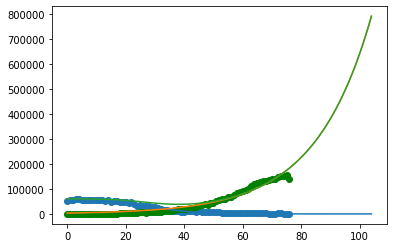

In [21]:
import matplotlib.pyplot as plt

plt.scatter(abs_data.index, abs_data.delta_abs)
plt.plot(np.array([i for i in range(len(delta_abs_fit))]), delta_abs_fit['fit'])

plt.scatter(abs_data.index, abs_data.ba1_abs, color='green')
plt.plot(np.array([i for i in range(len(ba1_abs_fit))]), ba1_abs_fit['fit'])

plt.plot(np.array([i for i in range(len(ba1_abs_fit))]), delta_abs_fit['fit']+ba1_abs_fit['fit'])

In [22]:
abs_data_fit = pd.concat([abs_data, delta_abs_fit[['fit']].rename({'fit': 'delta_abs_fit'}, axis=1)], axis=1)
abs_data_fit = pd.concat([abs_data_fit, omicron_abs_fit[['fit']].rename({'fit': 'omicron_abs_fit'}, axis=1)], axis=1)
abs_data_fit = pd.concat([abs_data_fit, ba1_abs_fit[['fit']].rename({'fit': 'ba1_abs_fit'}, axis=1)], axis=1)
abs_data_fit = pd.concat([abs_data_fit, ba2_abs_fit[['fit']].rename({'fit': 'ba2_abs_fit'}, axis=1)], axis=1)
abs_data_fit['new_cases_smoothed_fit'] = abs_data_fit['delta_abs_fit'] + abs_data_fit['omicron_abs_fit']
abs_data_fit.loc[len(abs_data.index):, 'date'] = pd.date_range(abs_data.iloc[-1].date, periods=forecast_days+1)[1:].map(lambda d: d.strftime('%Y-%m-%d'))

# abs_data_fit = abs_data_fit.join(omicron_growth_fit.set_index('date').rename({'fit': 'omicron_rel_fit'}, axis=1), on='date', how='left')
abs_data_fit['omicron_rel_fit'] = abs_data_fit.omicron_abs_fit / abs_data_fit.new_cases_smoothed_fit
abs_data_fit['ba1_rel_fit'] = abs_data_fit.ba1_abs_fit / abs_data_fit.new_cases_smoothed_fit
abs_data_fit['ba2_rel_fit'] = abs_data_fit.ba2_abs_fit / abs_data_fit.new_cases_smoothed_fit
abs_data_fit['delta_rel_fit'] = abs_data_fit.delta_abs_fit / abs_data_fit.new_cases_smoothed_fit

for _, row in owid_data_ger.iterrows():
  if row.date in abs_data_fit.date.unique():
    idx = abs_data_fit[abs_data_fit.date == row.date].index.item()
    abs_data_fit.loc[idx, 'new_cases_smoothed'] = row.new_cases_smoothed

data_fit = abs_data_fit

abs_data_fit

,date,delta_rel,omicron_rel,ba1_rel,ba2_rel,new_cases_smoothed,delta_abs,omicron_abs,ba1_abs,ba2_abs,delta_abs_fit,omicron_abs_fit,ba1_abs_fit,ba2_abs_fit,new_cases_smoothed_fit,omicron_rel_fit,ba1_rel_fit,ba2_rel_fit,delta_rel_fit
0,2021-11-23,0.999490,0.000255,0.000255,0.0,53113.714,53086.642790,13.535605,13.535605,0.0,56725.523070,3.120755e+03,3474.807201,28.809417,5.984628e+04,0.052146,0.058062,0.000481,0.947854
1,2021-11-24,0.998542,0.001203,0.001203,0.0,54640.143,54560.502189,65.716208,65.716208,0.0,56557.090119,3.299639e+03,3660.956152,31.618167,5.985673e+04,0.055126,0.061162,0.000528,0.944874
2,2021-11-25,0.998331,0.001414,0.001414,0.0,56898.857,56803.889552,80.467229,80.467229,0.0,56365.811554,3.488776e+03,3857.077291,34.700753,5.985459e+04,0.058288,0.064441,0.000580,0.941712
3,2021-11-26,0.997435,0.001862,0.001862,0.0,58082.000,57933.013771,108.162472,108.162472,0.0,56148.780655,3.688754e+03,4063.704839,38.083874,5.983753e+04,0.061646,0.067912,0.000636,0.938354
4,2021-11-27,0.995049,0.004248,0.004248,0.0,58052.571,57765.177823,246.590105,246.590105,0.0,55902.777212,3.900196e+03,4281.401634,41.796829,5.980297e+04,0.065217,0.071592,0.000699,0.934783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2022-03-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.311111,8.221026e+05,641670.617270,316050.083395,8.221069e+05,0.999995,0.780520,0.384439,0.000005
101,2022-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.772170,8.692259e+05,676045.563913,346863.117922,8.692297e+05,0.999996,0.777753,0.399047,0.000004
102,2022-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.300599,9.190504e+05,712262.011358,380680.243087,9.190537e+05,0.999996,0.774995,0.414209,0.000004
103,2022-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.887978,9.717309e+05,750418.610674,417794.340156,9.717337e+05,0.999997,0.772247,0.429947,0.000003


In [23]:
# project omicron 50% and 100% (>99%)
def project_omicron_above(p, popt):
  df = pd.DataFrame({'date': agg_data.date})
  df.index = agg_data.index

  idx_above = int(np.ceil(sigmoid_x(p, *popt)))

  if idx_above in df.index:
    return df.loc[idx_above].date
  
  diff = idx_above - df.index.max()
  last_day = time.strptime(df.iloc[-1]['date'], '%Y-%m-%d')
  return (date(last_day.tm_year, last_day.tm_mon, last_day.tm_mday) + timedelta(diff)).strftime('%Y-%m-%d')

### Single Data Points

In [24]:
import json 

sdps = []

def get_sdp_value(label, sdps):
  if sdps is None: return None
  return next((sdp['value_raw'] for sdp in sdps if sdp['label'] == label and 'value_raw' in sdp), None)

def get_diff_str(after, before, round_to=2):
  diff = float(after) - float(before)
  if diff >= 0: return f'+{round(diff, round_to)}'
  else: return f'{round(diff, round_to)}'

# load yesterday's sdps
try:
    yesterday_str = (date_to_process + timedelta(-1)).strftime('%Y-%m-%d')
    with open(f'data/historic/{yesterday_str}/sdps.json', 'r') as f:
        sdps_yesterday = json.load(f)
except:
    sdps_yesterday = None

# Reproduction Rate alltogether
label = 'R-Wert (' + str(owid_data_ger[['date', 'reproduction_rate']].dropna().iloc[-1].date) + ')'
value_raw = owid_data_ger.reproduction_rate.dropna().iloc[-1]
val_y = get_sdp_value(label, sdps_yesterday)
sdps.append({
    'label': label,
    'value': value_raw,
    'value_raw': value_raw,
    'hint': 'Kann nur nachhängig gemessen werden. R-Wert gesamt vom ' + str(owid_data_ger[['date', 'reproduction_rate']].dropna().iloc[-1].date),
    'change': get_diff_str(value_raw, val_y) if val_y is not None else None,
})

label = '7-Tage-Inzidenz'
value_raw = owid_data_ger.iloc[-1].new_cases_smoothed_per_million/10 * 7
val_y = owid_data_ger.iloc[-2].new_cases_smoothed_per_million/10 * 7
sdps.append({
    'label': label,
    'value': '{:.2f}'.format(value_raw),
    'value_raw': value_raw,
    'hint': 'Inzidenz mit Stand ' + owid_data_ger.iloc[-1].date,
    'change': get_diff_str(value_raw, val_y) if val_y is not None else None,
})

label = 'Verdopplungszeit'
value_raw = np.log(2) / np.log(1 + ((data_fit.iloc[-1]['new_cases_smoothed_fit'] - data_fit.iloc[-2]['new_cases_smoothed_fit']) / data_fit.iloc[-2]['new_cases_smoothed_fit']))
val_y = get_sdp_value(label, sdps_yesterday)
sdps.append({
    'label': label,
    'value': '{:.1f} Tage'.format(value_raw),
    'value_raw': value_raw,
    'hint': 'Verdopplungszeit der Fallzahlen auf Basis des aktuellen Wachstums.',
    'change': get_diff_str(value_raw, val_y) if val_y is not None else None,
})
value_raw = int(owid_data_ger.iloc[-1].new_cases)
sdps.append({
    'label': 'Neue Fälle gestern',
    'value': value_raw,
    'value_raw': value_raw,
    'hint': 'Neue gemeldete Fälle gestern, ' + owid_data_ger.iloc[-1].date,
    'change': None,
})

# Share of variants
value_raw = agg_data_rolling.iloc[-1].omicron_rel*100
sdps.append({
    'label': 'Anteil Omikron (' + str(agg_data_rolling.iloc[-1].date) + ')',
    'value': '{:.2f}%'.format(value_raw),
    'value_raw': value_raw,
    'hint': '3-Tagesdurchschnitt des relativen Anteils der Omikron-Variante an den Gesamtinfektionen. Stand: ' + agg_data_rolling.iloc[-1].date,
    'change': None,
})
value_raw = agg_data_rolling.iloc[-1].ba1_rel*100
sdps.append({
    'label': 'Anteil BA.1 (' + str(agg_data_rolling.iloc[-1].date) + ')',
    'value': '{:.2f}%'.format(value_raw),
    'value_raw': value_raw,
    'hint': '3-Tagesdurchschnitt des relativen Anteils des Omikron-Subtyps BA.1 an den Gesamtinfektionen. Stand: ' + agg_data_rolling.iloc[-1].date,
    'change': None,
})
value_raw = agg_data_rolling.iloc[-1].ba2_rel*100
sdps.append({
    'label': 'Anteil BA.2 (' + str(agg_data_rolling.iloc[-1].date) + ')',
    'value': '{:.2f}%'.format(value_raw),
    'value_raw': value_raw,
    'hint': '3-Tagesdurchschnitt des relativen Anteils des Omikron-Subtyps BA.2 an den Gesamtinfektionen. Stand: ' + agg_data_rolling.iloc[-1].date,
    'change': None,
})
value_raw = agg_data_rolling.iloc[-1].delta_rel*100
sdps.append({
    'label': 'Anteil Delta (' + str(agg_data_rolling.iloc[-1].date) + ')',
    'value': '{:.2f}%'.format(value_raw),
    'value_raw': value_raw,
    'hint': '3-Tagesdurchschnitt des relativen Anteils der Delta-Variante an den Gesamtinfektionen. Stand: ' + agg_data_rolling.iloc[-1].date,
    'change': None,
})

dft = data_fit[data_fit.date == date_to_process_str]
value_raw = 100 * dft.omicron_abs_fit.iloc[0] / dft.new_cases_smoothed_fit.iloc[0]
sdps.append({
    'label': 'Nowcast Anteil Omikron',
    'value': '{:.2f}%'.format(value_raw),
    'value_raw': value_raw,
    'hint': 'Projektion Anteil Omikron heute',
    'change': None,
})
value_raw = 100 * dft.delta_abs_fit.iloc[0] / dft.new_cases_smoothed_fit.iloc[0]
sdps.append({
    'label': 'Nowcast Anteil Delta',
    'value': '{:.2f}%'.format(value_raw),
    'value_raw': value_raw,
    'hint': 'Projektion Anteil Delta heute',
    'change': None,
})

if sdp_all:
  value_raw = project_omicron_above(0.5, popt_ogf)
  sdps.append({
      'label': 'Projektion Omikron 50%',
      'value': value_raw,
      'value_raw': value_raw,
      'hint': 'Projektion für Omikron-Anteil > 50%',
      'change': None,
  })
  value_raw = project_omicron_above(0.9, popt_ogf)
  sdps.append({
      'label': 'Projektion Omikron 90%',
      'value': value_raw,
      'value_raw': value_raw,
      'hint': 'Projektion für Omikron-Anteil > 90%',
      'change': None,
  })
  value_raw = project_omicron_above(0.95, popt_ogf)
  sdps.append({
      'label': 'Projektion Omikron 95%',
      'value': value_raw,
      'value_raw': value_raw,
      'hint': 'Projektion für Omikron-Anteil > 95%',
      'change': None,
  })
  value_raw = project_omicron_above(0.99, popt_ogf)
  sdps.append({
      'label': 'Projektion Omikron 99%',
      'value': value_raw,
      'value_raw': value_raw,
      'hint': 'Projektion für Omikron-Anteil > 99%',
      'change': None,
  })

today_idx = data_fit[data_fit.date == date_to_process_str].index.item()
one_week = (date_to_process + timedelta(7)).strftime('%Y-%m-%d')
one_week_idx = data_fit[data_fit.date == one_week].index.item()
two_weeks = (date_to_process + timedelta(14)).strftime('%Y-%m-%d')
two_weeks_idx = data_fit[data_fit.date == two_weeks].index.item()
three_weeks = (date_to_process + timedelta(21)).strftime('%Y-%m-%d')
three_weeks_idx = data_fit[data_fit.date == three_weeks].index.item()

value_raw = data_fit[data_fit.date == two_weeks].omicron_abs_fit.iloc[0]
sdps.append({
    'label': 'Projektion Omikron Fallzahlen in 14 Tagen',
    'value': round(value_raw),
    'value_raw': value_raw,
    'hint': 'Projektion für Omikron-Fallzahlen in 14 Tagen basierend auf aktuellem Wachstum.',
    'change': None,
})
value_raw = data_fit[data_fit.date == two_weeks].delta_abs_fit.iloc[0]
sdps.append({
    'label': 'Projektion Delta Fallzahlen in 14 Tagen',
    'value': round(value_raw),
    'value_raw': value_raw,
    'hint': 'Projektion für Delta-Fallzahlen in 14 Tagen basierend auf aktuellem Wachstum.',
    'change': None,
})

value_raw = (data_fit.new_cases_smoothed_fit.iloc[today_idx:one_week_idx+1].sum()/83240000)*100000
sdps.append({
    'label': 'Projektion 7-Tage-Inzidenz in 7 Tagen',
    'value': str(round(value_raw, 2)),
    'value_raw': value_raw,
    'hint': 'Basierend auf aktuellem Wachstum. Davon Delta: {:.2f}%, Omikron: {:.2f}%'.format(100 * data_fit.delta_rel_fit.iloc[one_week_idx], 100 * data_fit.omicron_rel_fit.iloc[one_week_idx]),
    'change': None,
})
if sdp_all:
  value_raw = (data_fit.new_cases_smoothed_fit.iloc[one_week_idx:two_weeks_idx+1].sum()/83240000)*100000
  sdps.append({
      'label': 'Projektion 7-Tage-Inzidenz in 14 Tagen',
      'value': str(round(value_raw, 2)),
      'value_raw': value_raw,
      'hint': 'Basierend auf aktuellem Wachstum. Davon Delta: {:.2f}%, Omikron: {:.2f}%'.format(100 * data_fit.delta_rel_fit.iloc[two_weeks_idx], 100 * data_fit.omicron_rel_fit.iloc[two_weeks_idx]),
      'change': None,
  })
  value_raw = (data_fit.new_cases_smoothed_fit.iloc[two_weeks_idx:three_weeks_idx+1].sum()/83240000)*100000
  sdps.append({
      'label': 'Projektion 7-Tage-Inzidenz in 21 Tagen',
      'value': str(round(value_raw, 2)),
      'value_raw': value_raw,
      'hint': 'Basierend auf aktuellem Wachstum. Davon Delta: {:.2f}%, Omikron: {:.2f}%'.format(100 * data_fit.delta_rel_fit.iloc[three_weeks_idx], 100 * data_fit.omicron_rel_fit.iloc[three_weeks_idx]),
      'change': None,
  })

  cur_idx = 0
  last_cases = data_fit.loc[cur_idx, 'new_cases_smoothed_fit']
  cur_idx += 1
  while cur_idx <= data_fit.index.max() and last_cases >= data_fit.loc[cur_idx, 'new_cases_smoothed_fit']:
    last_cases = data_fit.loc[cur_idx, 'new_cases_smoothed_fit']
    cur_idx += 1

  if cur_idx <= data_fit.index.max():
    value_raw = data_fit.loc[cur_idx, 'date']
    sdps.append({
        'label': 'Steigende Fälle ab',
        'value': value_raw,
        'value_raw': value_raw,
        'hint': 'Datum, ab welchem Fallzahlen wieder steigen (Projektion)',
        'change': None,
    })

sdps

[{'label': 'R-Wert (2022-02-08)',
  'value': 1.27,
  'value_raw': 1.27,
  'hint': 'Kann nur nachhängig gemessen werden. R-Wert gesamt vom 2022-02-08',
  'change': None},
 {'label': '7-Tage-Inzidenz',
  'value': '1602.81',
  'value_raw': 1602.8124,
  'hint': 'Inzidenz mit Stand 2022-02-10',
  'change': '-14.98'},
 {'label': 'Verdopplungszeit',
  'value': '12.4 Tage',
  'value_raw': 12.435946583463307,
  'hint': 'Verdopplungszeit der Fallzahlen auf Basis des aktuellen Wachstums.',
  'change': '+1.27'},
 {'label': 'Neue Fälle gestern',
  'value': 236080,
  'value_raw': 236080,
  'hint': 'Neue gemeldete Fälle gestern, 2022-02-10',
  'change': None},
 {'label': 'Anteil Omikron (2022-02-07)',
  'value': '99.74%',
  'value_raw': 99.74160206718346,
  'hint': '3-Tagesdurchschnitt des relativen Anteils der Omikron-Variante an den Gesamtinfektionen. Stand: 2022-02-07',
  'change': None},
 {'label': 'Anteil BA.1 (2022-02-07)',
  'value': '82.85%',
  'value_raw': 82.84910939813605,
  'hint': '3-Tag

In [25]:
data_fit

,date,delta_rel,omicron_rel,ba1_rel,ba2_rel,new_cases_smoothed,delta_abs,omicron_abs,ba1_abs,ba2_abs,delta_abs_fit,omicron_abs_fit,ba1_abs_fit,ba2_abs_fit,new_cases_smoothed_fit,omicron_rel_fit,ba1_rel_fit,ba2_rel_fit,delta_rel_fit
0,2021-11-23,0.999490,0.000255,0.000255,0.0,53113.714,53086.642790,13.535605,13.535605,0.0,56725.523070,3.120755e+03,3474.807201,28.809417,5.984628e+04,0.052146,0.058062,0.000481,0.947854
1,2021-11-24,0.998542,0.001203,0.001203,0.0,54640.143,54560.502189,65.716208,65.716208,0.0,56557.090119,3.299639e+03,3660.956152,31.618167,5.985673e+04,0.055126,0.061162,0.000528,0.944874
2,2021-11-25,0.998331,0.001414,0.001414,0.0,56898.857,56803.889552,80.467229,80.467229,0.0,56365.811554,3.488776e+03,3857.077291,34.700753,5.985459e+04,0.058288,0.064441,0.000580,0.941712
3,2021-11-26,0.997435,0.001862,0.001862,0.0,58082.000,57933.013771,108.162472,108.162472,0.0,56148.780655,3.688754e+03,4063.704839,38.083874,5.983753e+04,0.061646,0.067912,0.000636,0.938354
4,2021-11-27,0.995049,0.004248,0.004248,0.0,58052.571,57765.177823,246.590105,246.590105,0.0,55902.777212,3.900196e+03,4281.401634,41.796829,5.980297e+04,0.065217,0.071592,0.000699,0.934783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2022-03-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.311111,8.221026e+05,641670.617270,316050.083395,8.221069e+05,0.999995,0.780520,0.384439,0.000005
101,2022-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.772170,8.692259e+05,676045.563913,346863.117922,8.692297e+05,0.999996,0.777753,0.399047,0.000004
102,2022-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.300599,9.190504e+05,712262.011358,380680.243087,9.190537e+05,0.999996,0.774995,0.414209,0.000004
103,2022-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.887978,9.717309e+05,750418.610674,417794.340156,9.717337e+05,0.999997,0.772247,0.429947,0.000003


In [26]:
os.system('mkdir -p data/growth_fit')
os.system(f'mkdir -p data/historic/{date_to_process}')
os.system(f'mkdir -p data/historic/{date_to_process}/growth_fit')

def save_data(data, filename):
  data.to_csv(f'data/{filename}', index=False)
  data.to_csv(f'data/historic/{date_to_process_str}/{filename}', index=False)

save_data(agg_data, 'agg_data.csv')
save_data(agg_data_rolling, 'agg_data_rolling.csv')

save_data(delta_growth_fit, 'growth_fit/delta.csv')
save_data(omicron_growth_fit.iloc[:-14], 'growth_fit/omicron.csv')
save_data(ba1_growth_fit.iloc[:-14], 'growth_fit/ba1.csv')
save_data(ba2_growth_fit.iloc[:-14], 'growth_fit/ba2.csv')

save_data(data_fit, 'projection.csv')

with open("data/sdps.json", "w") as fp:
    json.dump(sdps , fp) 
with open(f"data/historic/{date_to_process}/sdps.json", "w") as fp:
    json.dump(sdps , fp)

In [27]:
os.system('rm meta.csv')
os.system('rm meta.csv.xz')
os.system('rm variants.csv')
os.system('rm variants.csv.xz')

0